In [ ]:
import pandas as pd
import re

# ============================================
# LOAD DATA dari sheet Fix
# ============================================
path = "Meta Data.xlsx"
df = pd.read_excel(path, sheet_name="Fix")

print("=== Raw Data ===")
print(df.head())


df["Cleaned_Headline"] = df["Headline"].astype(str).apply(lambda x: x.strip())


# MAPPING
label_mapping = {
    0: "HOAX",
    1: "VALID"
}

df["Category"] = df["Label"].map(label_mapping)


# PREVIEW OUTPUT
print("\n=== Processed Data ===")
print(df[["Label", "Category", "Cleaned_Headline"]].head())


# OPSIONAL: SIMPAN HASIL KE FILE BARU
df.to_excel("Processed_Meta_Data.xlsx", index=False)
print("\nFile berhasil disimpan sebagai: Processed_Meta_Data.xlsx")


=== Raw Data ===
   Label                                           Headline  \
0      1  Pertamina dan Pemerintah Kalrifikasi Isu BBM N...   
1      1  Polda Nusa Tenggara Barat Mengklarifkasi Bahwa...   
2      1  PT Ultrajaya Milk Industry Tbk Mengklarifikasi...   
3      1  BBKSDA Jatim Mengklarifikasi Bahwa Wisata Alam...   
4      1  BMKG Mataram Menghimbau Agar Warga Tidak Langs...   

                                                Body  
0  Foto: Kumparan.com Debunk ini berisi iKlarifik...  
1  Foto Ilustrasi Perkosaan Debunk ini berisi kla...  
2  Debunk ini berisi klarifikasi dari PT Ultrajay...  
3  foto: tribunnews.com Debunk ini berisi Klrifik...  
4  Foto: tribunnews.com (Jokowi sedang memantau l...  

=== Processed Data ===
   Label Category                                   Cleaned_Headline
0      1    VALID  Pertamina dan Pemerintah Kalrifikasi Isu BBM N...
1      1    VALID  Polda Nusa Tenggara Barat Mengklarifkasi Bahwa...
2      1    VALID  PT Ultrajaya Milk Indust

In [ ]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import numpy as np

# Tokenize
MODEL_NAME = 'indolem/indobert-base-uncased'
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded successfully.")

# Encode labels
unique_labels = df['Label'].unique().tolist()
label_map = {label: i for i, label in enumerate(unique_labels)}
labels_full = df['Label'].map(label_map).values

label_counts = pd.Series(labels_full).value_counts()
labels_to_exclude = label_counts[label_counts < 2].index.tolist()
mask_stratify = ~pd.Series(labels_full).isin(labels_to_exclude)
df_strat = df[mask_stratify].copy()
labels_strat = df_strat['Label'].map(label_map).values

# Tokenize
MAX_LENGTH = 128
texts_strat = df_strat['Cleaned_Headline'].astype(str).tolist()
encoded_data = tokenizer.batch_encode_plus(
    texts_strat,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']
token_type_ids = encoded_data['token_type_ids']
labels_tensor = torch.tensor(labels_strat)

# Train-test split
train_inputs, val_inputs, \
train_labels, val_labels, \
train_masks, val_masks, \
train_token_types, val_token_types = train_test_split(
    input_ids,
    labels_tensor,
    attention_mask,
    token_type_ids,
    random_state=42,
    test_size=0.2,
    stratify=labels_tensor.cpu().numpy()
)

print("Data split into training and validation sets.")


Loading tokenizer for indolem/indobert-base-uncased...
Tokenizer loaded successfully.
Data split into training and validation sets.


In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 32

# Training DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_token_types, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Validation DataLoader
val_data = TensorDataset(val_inputs, val_masks, val_token_types, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

print(f"Training batches: {len(train_dataloader)}, Validation batches: {len(val_dataloader)}")


Training batches: 28, Validation batches: 7


In [12]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

num_labels = len(label_map)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model loaded and moved to {device}")

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cpu


In [13]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 5
TOTAL_STEPS = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=TOTAL_STEPS
)
print(f"Scheduler created for {EPOCHS} epochs ({TOTAL_STEPS} steps)")


Scheduler created for 5 epochs (140 steps)


In [14]:
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def calculate_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return acc, prec, rec, f1

# Training
for epoch_i in range(EPOCHS):
    print(f"\n===== Epoch {epoch_i+1}/{EPOCHS} =====")
    model.train()
    total_loss = 0
    predictions_train, true_train = [], []

    for batch in tqdm(train_dataloader, desc="Training"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=b_token_type_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions_train.extend(np.argmax(logits, axis=1).flatten())
        true_train.extend(label_ids.flatten())

    avg_loss = total_loss / len(train_dataloader)
    acc, prec, rec, f1 = calculate_metrics(predictions_train, true_train)
    print(f"Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

    # Validation
    model.eval()
    total_eval_loss = 0
    predictions_val, true_val = [], []

    for batch in tqdm(val_dataloader, desc="Validating"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=b_token_type_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions_val.extend(np.argmax(logits, axis=1).flatten())
        true_val.extend(label_ids.flatten())

    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(predictions_val, true_val)
    print(f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")



===== Epoch 1/5 =====


Training:   0%|          | 0/28 [00:00<?, ?it/s]

Training: 100%|██████████| 28/28 [06:12<00:00, 13.31s/it]


Train Loss: 0.6312, Acc: 0.6547, F1: 0.6224


Validating: 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


Val Loss: 0.5465, Acc: 0.7366, F1: 0.7363

===== Epoch 2/5 =====


Training: 100%|██████████| 28/28 [05:52<00:00, 12.61s/it]


Train Loss: 0.4729, Acc: 0.7803, F1: 0.7741


Validating: 100%|██████████| 7/7 [00:22<00:00,  3.23s/it]


Val Loss: 0.3856, Acc: 0.8080, F1: 0.8104

===== Epoch 3/5 =====


Training: 100%|██████████| 28/28 [06:06<00:00, 13.09s/it]


Train Loss: 0.3649, Acc: 0.8397, F1: 0.8388


Validating: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]


Val Loss: 0.3229, Acc: 0.8661, F1: 0.8668

===== Epoch 4/5 =====


Training: 100%|██████████| 28/28 [05:54<00:00, 12.65s/it]


Train Loss: 0.2776, Acc: 0.8890, F1: 0.8884


Validating: 100%|██████████| 7/7 [00:20<00:00,  3.00s/it]


Val Loss: 0.3206, Acc: 0.8571, F1: 0.8581

===== Epoch 5/5 =====


Training: 100%|██████████| 28/28 [05:30<00:00, 11.81s/it]


Train Loss: 0.2601, Acc: 0.8946, F1: 0.8928


Validating: 100%|██████████| 7/7 [00:20<00:00,  2.96s/it]

Val Loss: 0.3050, Acc: 0.8661, F1: 0.8666



Final Validation Metrics:


,Metric,Value
0,Accuracy,0.866071
1,Precision,0.867662
2,Recall,0.866071
3,F1-Score,0.866584


C:\Users\fx506\AppData\Local\Temp\ipykernel_19796\1460371921.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')


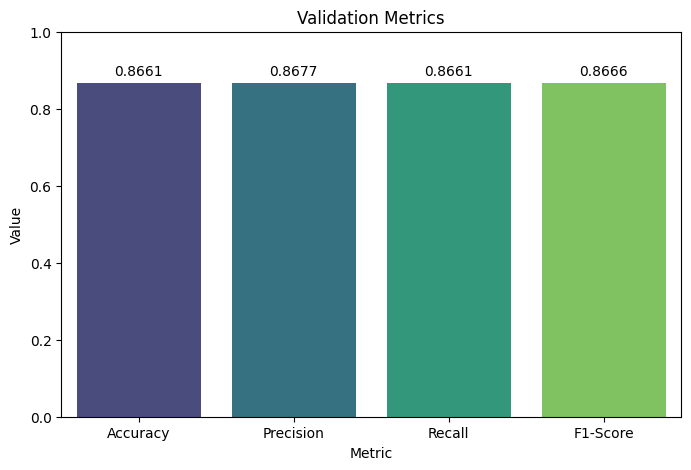

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [val_acc, val_prec, val_rec, val_f1]
}

metrics_df = pd.DataFrame(metrics)
print("\nFinal Validation Metrics:")
display(metrics_df)

plt.figure(figsize=(8,5))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')
plt.ylim(0,1)
for i, v in enumerate(metrics['Value']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.title("Validation Metrics")
plt.show()


In [ ]:

# SAVE MODEL
save_dir = "saved_finetuning_indobert_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("\nModel berhasil disimpan ke:", save_dir)


Model berhasil disimpan ke: saved_finetuning_indobert_model
